In [1]:
import os

In [2]:
os.chdir("../")

In [18]:
%pwd

'/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/research'

# Configure config.yaml which holds information about where our data will be stored

In [ ]:
# Configuration related to data transformation
data_transformation:
  # Directory where data transformation results and artifacts are stored
  root_dir: artifacts/data_transformation
  
  # Path to the ingested data file that will be used for validation
  data_source_file: artifacts/data_ingestion/gsearch_jobs.csv

  # Path to data validation status
  data_validation: artifacts/data_validation/status.txt

  # Path to normalization dictionary
  normalization_dict: artifacts/data_transformation/normalization_dict.json

# Setup Entity

In [4]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """
    Configuration for the data transformation process.
    
    This configuration class captures the necessary paths and directories 
    required for the transformation of data post-ingestion and pre-model training.
    
    Attributes:
    - root_dir: Directory where data transformation results and artifacts are stored.
    - data_source_file: Path to the file where the ingested data is stored that needs to be transformed.
    """
    
    root_dir: Path  # Directory for storing transformation results and related artifacts
    data_source_file: Path  # Path to the ingested data file for transformation
    data_validation: Path # Path to the validated output file
    normalization_dict: Path # Path to our abbreviation normalized dictionary

# Configure the Configuration Manager

In [5]:
from src.career_chief.constants import *
from src.career_chief.utils.common import read_yaml, create_directories
from src.career_chief import logger
from src.career_chief.entity.config_entity import (DataIngestionConfig, DataValidationConfig)

class ConfigurationManager:
    """
    ConfigurationManager manages configurations needed for the data pipeline.

    The class reads configuration, parameter, and schema settings from specified files
    and provides a set of methods to access these settings. It also takes care of
    creating necessary directories defined in the configurations.

    Attributes:
    - config (dict): Configuration settings.
    - params (dict): Parameters for the pipeline.
    - schema (dict): Schema information.
    """
    
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH, 
                 params_filepath = PARAMS_FILE_PATH, 
                 schema_filepath = SCHEMA_FILE_PATH) -> None:
        """
        Initialize ConfigurationManager with configurations, parameters, and schema.

        Args:
        - config_filepath (Path): Path to the configuration file.
        - params_filepath (Path): Path to the parameters file.
        - schema_filepath (Path): Path to the schema file.

        Creates:
        - Directories specified in the configuration.
        """
        self.config = self._read_config_file(config_filepath, "config")
        self.params = self._read_config_file(params_filepath, "params")
        self.schema = self._read_config_file(schema_filepath, "schema")

        # Create the directory for storing artifacts if it doesn't exist
        create_directories([self.config.artifacts_root])

    def _read_config_file(self, filepath: str, config_name: str) -> dict:
        """
        Read a configuration file and return its content.

        Args:
        - filepath (str): Path to the configuration file.
        - config_name (str): Name of the configuration (for logging purposes).

        Returns:
        - dict: Configuration settings.

        Raises:
        - Exception: If there's an error reading the file.
        """
        try:
            return read_yaml(filepath)
        except Exception as e:
            logger.error(f"Error reading {config_name} file: {filepath}. Error: {e}")
            raise

    
    def get_data_transformation_config(self) -> DataTransformationConfig:
        """
        Extract and return data transformation configurations as a DataTransformationConfig object.

        This method fetches settings related to data transformation, like directories and file paths,
        and returns them as a DataTransformationConfig object.

        Returns:
        - DataTransformationConfig: Object containing data transformation configuration settings.

        Raises:
        - AttributeError: If the 'data_transformation' attribute does not exist in the config file.
        """
        try:
            config = self.config.data_transformation
            
            # Ensure the root directory for data transformation exists
            create_directories([config.root_dir])

            # Construct and return the DataTransformationConfig object
            return DataTransformationConfig(
                root_dir=Path(config.root_dir),
                data_source_file=Path(config.data_source_file),
                data_validation=Path(config.data_validation),
                normalization_dict=Path(config.normalization_dict),
            )

        except AttributeError as e:
            # Log the error and re-raise the exception for handling by the caller
            logger.error("The 'data_transformation' attribute does not exist in the config file.")
            raise e

# Build Component

In [6]:
import pandas as pd
import re
import spacy
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sklearn.model_selection import train_test_split
from datasets import Dataset
import os
import json
from src.career_chief import logger

class DataTransformation:
    """
    Preprocesses technical resume data for NLP tasks, including noise removal, technical term normalization,
    tokenization, and named entity recognition (NER). Processes are optimized for efficiency and clarity.
    """

    def __init__(self, config):
        """
        Initializes the DataTransformation class with configuration settings.

        Args:
            config (object): Configuration object containing necessary settings such as file paths and model details.
        """
        self.config = config
        self.nlp = spacy.load("en_core_web_sm")  # Load spaCy English model
        self.tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")  # Hugging Face tokenizer
        self.model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")  # NER model
        self.nlp_pipeline = pipeline("ner", model=self.model, tokenizer=self.tokenizer)  # NER pipeline
        self.normalization_dict = self._load_normalization_dict()  # Load normalization dictionary
        self.df = self._load_data()  # Load dataset
        logger.info("DataTransformation initialized with provided configuration.")

    def _load_data(self):
        """Loads data from the specified CSV file."""
        try:
            df = pd.read_csv(self.config.data_source_file)
            logger.info("Data loaded successfully from {}".format(self.config.data_source_file))
            return df
        except Exception as e:
            logger.error("Failed to load data from {}: {}".format(self.config.data_source_file, e))
            raise

    def _load_normalization_dict(self):
        """Loads the normalization dictionary from a JSON file."""
        try:
            with open(self.config.normalization_dict) as f:
                normalization_dict = json.load(f)
            logger.info("Normalization dictionary loaded successfully.")
            return normalization_dict
        except Exception as e:
            logger.error("Failed to load normalization dictionary: {}".format(e))
            raise

    def preprocess_and_transform(self):
        """Executes the full preprocessing and transformation pipeline."""
        logger.info("Starting preprocessing and transformation pipeline.")
        self._remove_noise()
        self._normalize_technical_terms()
        self._tokenize_text()
        self._apply_ner()
        self._split_data()
        logger.info("Preprocessing and transformation pipeline completed.")

    def _remove_noise(self):
        """Removes noise such as special characters from the text descriptions."""
        tqdm.pandas(desc="Removing Noise")
        self.df['cleaned_text'] = self.df['description'].progress_apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
        logger.info("Noise removed from text.")

    def _normalize_technical_terms(self):
        """Normalizes technical terms using the provided normalization dictionary."""
        tqdm.pandas(desc="Normalizing Technical Terms")
        def normalize_text(text):
            for abbr, full_form in self.normalization_dict.items():
                text = re.sub(r'\b{}\b'.format(abbr), full_form, text, flags=re.IGNORECASE)
            return text
        self.df['cleaned_text'] = self.df['cleaned_text'].progress_apply(normalize_text)
        logger.info("Technical terms normalized.")

    def _tokenize_text(self):
        """Tokenizes the cleaned text with automatic truncation to the maximum sequence length."""
        max_token_length = 512
        tqdm.pandas(desc="Tokenizing Text")
        self.df['tokens'] = self.df['cleaned_text'].progress_apply(
            lambda x: self.tokenizer(x, truncation=True, max_length=max_token_length)['input_ids'])
        logger.info("Text tokenized with automatic truncation to max length.")


    def _apply_ner(self):
        """Applies named entity recognition (NER) to identify entities within the text."""
        tqdm.pandas(desc="Applying NER")
        self.df['ner_results'] = self.df['cleaned_text'].progress_apply(self.nlp_pipeline)
        logger.info("NER applied to text.")

    def _split_data(self, test_size=0.2, val_size=0.1):
        """Splits the dataset into training, validation, and testing sets."""
        train_val, test = train_test_split(self.df, test_size=test_size)
        train, val = train_test_split(train_val, test_size=val_size / (1 - test_size))
        self.train_data, self.val_data, self.test_data = train, val, test
        logger.info("Data split into training, validation, and test sets.")

    def save_data(self, dataset, filename):
        """Saves the processed dataset to a CSV file."""
        filepath = os.path.join(self.config.root_dir, filename)
        try:
            dataset.to_csv(filepath, index=False)
            logger.info("Dataset saved to {}".format(filepath))
        except Exception as e:
            logger.error("Failed to save dataset to {}: {}".format(filepath, e))


[2024-03-11 17:15:25,073: 58: datasets: INFO: config:  PyTorch version 2.1.2 available.]


# Build Pipeline

In [8]:
from src.career_chief.entity.config_entity import DataTransformationConfig  # Import the configuration class
from src.career_chief import logger
from datasets import Dataset
import os

class DataTransformationPipeline:
    """
    Orchestrates the data transformation process including preprocessing, NER,
    and splitting the data into training, validation, and testing datasets.
    """

    STAGE_NAME = "Data Transformation Pipeline"

    def __init__(self):
        """
        Initializes the DataTransformationPipeline with configurations obtained from the ConfigurationManager.
        """
        self.config_manager = ConfigurationManager()
        transformation_config = self.config_manager.get_data_transformation_config()
        self.data_transformation = DataTransformation(transformation_config)
        logger.info("{} initialized.".format(self.STAGE_NAME))

    def run_pipeline(self):
        """
        Executes the data transformation process and returns transformed datasets.
        
        Returns:
            train_ds (Dataset): The training dataset.
            val_ds (Dataset): The validation dataset.
            test_ds (Dataset): The testing dataset.
        """
        logger.info(f"{self.STAGE_NAME}: Starting the data transformation process.")
        # Preprocess and transform data
        self.data_transformation.preprocess_and_transform()

        # Saving the processed data
        self.save_transformed_data(self.data_transformation.train_data, 'train_data.csv')
        self.save_transformed_data(self.data_transformation.val_data, 'val_data.csv')
        self.save_transformed_data(self.data_transformation.test_data, 'test_data.csv')
        
        # Convert to Hugging Face datasets for compatibility
        train_ds = Dataset.from_pandas(self.data_transformation.train_data)
        val_ds = Dataset.from_pandas(self.data_transformation.val_data)
        test_ds = Dataset.from_pandas(self.data_transformation.test_data)

        logger.info(f"{self.STAGE_NAME}: Data transformation process completed.")
        return train_ds, val_ds, test_ds

    def save_transformed_data(self, dataset, filename):
        """
        Saves the transformed dataset to a CSV file in the specified directory.
        
        Args:
            dataset (pd.DataFrame): The dataset to save.
            filename (str): The filename for the saved dataset.
        """
        filepath = os.path.join(self.data_transformation.config.root_dir, filename)
        try:
            dataset.to_csv(filepath, index=False)
            logger.info(f"Transformed dataset saved to {filepath}")
        except Exception as e:
            logger.error(f"Failed to save transformed dataset to {filepath}: {e}")

if __name__ == '__main__':
    pipeline = DataTransformationPipeline()
    train_ds, val_ds, test_ds = pipeline.run_pipeline()
    # Further processing or model training can now be performed on these datasets
    logger.info(f"Training dataset size: {len(train_ds)}")
    logger.info(f"Validation dataset size: {len(val_ds)}")
    logger.info(f"Testing dataset size: {len(test_ds)}")


[2024-03-11 17:17:29,860: 41: career_chief_logger: INFO: common:  yaml file: config/config.yaml loaded successfully]
[2024-03-11 17:17:29,862: 41: career_chief_logger: INFO: common:  yaml file: params.yaml loaded successfully]
[2024-03-11 17:17:29,865: 41: career_chief_logger: INFO: common:  yaml file: schema.yaml loaded successfully]
[2024-03-11 17:17:29,865: 64: career_chief_logger: INFO: common:  Created directory at: artifacts]
[2024-03-11 17:17:29,866: 64: career_chief_logger: INFO: common:  Created directory at: artifacts/data_transformation]


Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[2024-03-11 17:17:35,150: 49: career_chief_logger: INFO: 2851148029:  Normalization dictionary loaded successfully.]
[2024-03-11 17:17:36,973: 38: career_chief_logger: INFO: 2851148029:  Data loaded successfully from artifacts/data_ingestion/gsearch_jobs.csv]
[2024-03-11 17:17:36,974: 32: career_chief_logger: INFO: 2851148029:  DataTransformation initialized with provided configuration.]
[2024-03-11 17:17:36,974: 21: career_chief_logger: INFO: 3498145602:  Data Transformation Pipeline initialized.]
[2024-03-11 17:17:36,974: 32: career_chief_logger: INFO: 3498145602:  Data Transformation Pipeline: Starting the data transformation process.]
[2024-03-11 17:17:36,975: 57: career_chief_logger: INFO: 2851148029:  Starting preprocessing and transformation pipeline.]


Removing Noise:   0%|          | 0/37962 [00:00<?, ?it/s]

[2024-03-11 17:17:38,271: 69: career_chief_logger: INFO: 2851148029:  Noise removed from text.]


Normalizing Technical Terms:   0%|          | 0/37962 [00:00<?, ?it/s]

[2024-03-11 17:21:07,037: 79: career_chief_logger: INFO: 2851148029:  Technical terms normalized.]


Tokenizing Text:   0%|          | 0/37962 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


[2024-03-11 17:21:49,131: 87: career_chief_logger: INFO: 2851148029:  Text tokenized and truncated to max length.]


Applying NER:   0%|          | 0/37962 [00:00<?, ?it/s]

[2024-03-12 01:12:29,558: 93: career_chief_logger: INFO: 2851148029:  NER applied to text.]
[2024-03-12 01:12:55,321: 100: career_chief_logger: INFO: 2851148029:  Data split into training, validation, and test sets.]
[2024-03-12 01:12:55,333: 63: career_chief_logger: INFO: 2851148029:  Preprocessing and transformation pipeline completed.]
[2024-03-12 01:13:34,054: 60: career_chief_logger: INFO: 3498145602:  Transformed dataset saved to artifacts/data_transformation/train_data.csv]
[2024-03-12 01:13:40,586: 60: career_chief_logger: INFO: 3498145602:  Transformed dataset saved to artifacts/data_transformation/val_data.csv]
[2024-03-12 01:13:56,106: 60: career_chief_logger: INFO: 3498145602:  Transformed dataset saved to artifacts/data_transformation/test_data.csv]
[2024-03-12 01:14:19,306: 46: career_chief_logger: INFO: 3498145602:  Data Transformation Pipeline: Data transformation process completed.]
[2024-03-12 01:14:19,318: 68: career_chief_logger: INFO: 3498145602:  Training dataset 

In [9]:
import pandas as pd
from IPython.display import display

def load_and_inspect_transformed_data(train_path, test_path, val_path):
    """
    Loads the transformed datasets from specified paths and displays their basic information
    using IPython's display function for a more interactive visualization.
    
    Args:
        train_path (str): Path to the training dataset CSV.
        test_path (str): Path to the testing dataset CSV.
        val_path (str): Path to the validation dataset CSV.
    """
    
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    val_df = pd.read_csv(val_path)
    
    # Inspect each dataset
    for name, df in zip(["Training", "Testing", "Validation"], [train_df, test_df, val_df]):
        print(f"\n{name} dataset:")
        print(f"Shape: {df.shape}")
        print("First 5 rows:")
        display(df.head())
        print("\nBasic statistics:")
        display(df.describe().transpose())
        # Add more analysis or visualization as needed

# Example usage
train_path = 'artifacts/data_transformation/train_data.csv'
test_path = 'artifacts/data_transformation/test_data.csv'
val_path = 'artifacts/data_transformation/val_data.csv'

load_and_inspect_transformed_data(train_path, test_path, val_path)



Training dataset:
Shape: (26572, 30)
First 5 rows:


,Unnamed: 0,index,title,company_name,location,via,description,extensions,job_id,thumbnail,...,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized,description_tokens,cleaned_text,tokens,ner_results
0,30200,827,Senior Data Analyst,Planet Technology,Anywhere,via LinkedIn,Our Client is looking for a full-time Sr. Data...,"['10 hours ago', 'Work from home', 'Full-time']",eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,"['excel', 'bigquery', 'redshift', 'sql', 'powe...",Our Client is looking for a fulltime Sr Data A...,"['Our', 'C', '##lient', 'is', 'looking', 'for'...","[{'entity': 'B-MISC', 'score': 0.6366868, 'ind..."
1,13682,652,Data Analysis,Upwork,Anywhere,via Upwork,We are seeking a skilled data analyst to join ...,"['19 hours ago', 'Work from home', 'Contractor...",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c2lzIiwiaHRpZG...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,[],We are seeking a skilled data analyst to join ...,"['We', 'are', 'seeking', 'a', 'skilled', 'data...",[]
2,3935,1901,Google Analytics GA4 Adjustment,Upwork,Anywhere,via Upwork,We are seeking a skilled professional to adjus...,"['12 hours ago', '10–46 an hour', 'Work from h...",eyJqb2JfdGl0bGUiOiJHb29nbGUgQW5hbHl0aWNzIEdBNC...,NaN,...,28.0,10.0,46.0,28.0,NaN,58240.0,[],We are seeking a skilled professional to adjus...,"['We', 'are', 'seeking', 'a', 'skilled', 'prof...","[{'entity': 'B-MISC', 'score': 0.8648094, 'ind..."
3,26125,2684,Data analyst sql and etl data management,Upwork,Anywhere,via Upwork,It's totally about data analysis and looking f...,"['14 hours ago', '8–15 an hour', 'Work from ho...",eyJqb2JfdGl0bGUiOiJEYXRhIGFuYWx5c3Qgc3FsIGFuZC...,NaN,...,11.5,8.0,15.0,11.5,NaN,23920.0,"['excel', 'sql']",Its totally about data analysis and looking fo...,"['Its', 'totally', 'about', 'data', 'analysis'...","[{'entity': 'B-MISC', 'score': 0.8927205, 'ind..."
4,24366,925,Reporting and Data Enablement Analyst (Remote),Vail Resorts,Anywhere,via Indeed,As a leading mountain resort operator with ove...,"['16 hours ago', '82,800–106,425 a year', 'Wor...",eyJqb2JfdGl0bGUiOiJSZXBvcnRpbmcgYW5kIERhdGEgRW...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,94612.5,82800.0,106425.0,NaN,94612.5,94612.5,"['jira', 'python', 'atlassian', 'snowflake', '...",As a leading mountain resort operator with ove...,"['As', 'a', 'leading', 'mountain', 'resort', '...","[{'entity': 'B-MISC', 'score': 0.63972175, 'in..."



Basic statistics:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,26572.0,18958.853116,10955.638068,5.00,9489.75,18913.5,28443.25,37959.0
index,26572.0,1123.900497,708.459680,0.00,534.00,1085.0,1641.00,3537.0
commute_time,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_avg,4553.0,34627.321422,51257.459590,7.25,30.00,57.5,85000.00,300000.0
salary_min,4283.0,28934.018394,43007.870333,8.00,18.33,40.0,74300.00,275000.0
salary_max,4283.0,40824.664466,60594.691036,10.00,42.60,75.0,100000.00,325000.0
salary_hourly,2995.0,41.637621,22.758898,7.25,25.00,35.0,57.50,300.0
salary_yearly,1550.0,101600.679471,30259.611520,30000.00,85000.00,96500.0,112500.00,300000.0
salary_standardized,4553.0,91696.906686,42855.061688,15080.00,62400.00,90000.0,115440.00,624000.0



Testing dataset:
Shape: (7593, 30)
First 5 rows:


,Unnamed: 0,index,title,company_name,location,via,description,extensions,job_id,thumbnail,...,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized,description_tokens,cleaned_text,tokens,ner_results
0,24661,1220,Developer needed for data analysis,Upwork,Anywhere,via Upwork,I am looking for a python programmer to find o...,"['4 hours ago', 'Work from home', 'Contractor']",eyJqb2JfdGl0bGUiOiJEZXZlbG9wZXIgbmVlZGVkIGZvci...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,['python'],I am looking for a python programmer to find o...,"['I', 'am', 'looking', 'for', 'a', 'p', '##yt'...","[{'entity': 'B-MISC', 'score': 0.49905413, 'in..."
1,2551,517,Senior Data Analyst,Humana,"Overland Park, KS",via BeBee,Description\nHumana's Clinical Pharmacy Review...,"['8 hours ago', 'Full-time', 'No degree mentio...",eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,"['excel', 'power_bi', 'sql', 'sas', 'azure', '...",Description\nHumanas Clinical Pharmacy Review ...,"['Des', '##cription', 'Human', '##as', 'Clinic...","[{'entity': 'B-ORG', 'score': 0.9582342, 'inde..."
2,37053,1399,Senior Data Analyst Business Optimization Inte...,Cox Communications,"Warr Acres, OK",via ZipRecruiter,Senior Data Analyst\n\nThe Consumer Analytics ...,"['18 hours ago', '77K–116K a year', 'Full-time...",eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0IE...,NaN,...,96500.0,77000.0,116000.0,NaN,96500.0,96500.0,"['snowflake', 'tableau', 'excel', 'sql', 'aws'...",Senior Data Analyst\n\nThe Consumer Analytics ...,"['Senior', 'Data', 'Ana', '##ly', '##st', 'The...","[{'entity': 'B-ORG', 'score': 0.76681745, 'ind..."
3,6295,46,Database Analyst,Professional Diversity Network,United States,via Jobs Trabajo.org,"The National Institute of Nursing Research, De...","['11 hours ago', 'Full-time and Part-time']",eyJqb2JfdGl0bGUiOiJEYXRhYmFzZSBBbmFseXN0IiwiaH...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,['excel'],The National Institute of Nursing Research Dep...,"['The', 'National', 'Institute', 'of', 'Nursin...","[{'entity': 'B-ORG', 'score': 0.9987381, 'inde..."
4,20002,397,Workday Reporting/Data Analyst,Corporate,"Kansas City, MO",via WREG Jobs,You could be the one who changes everything fo...,"['13 hours ago', 'Full-time', 'Health insuranc...",eyJqb2JfdGl0bGUiOiJXb3JrZGF5IFJlcG9ydGluZy9EYX...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,['excel'],You could be the one who changes everything fo...,"['You', 'could', 'be', 'the', 'one', 'who', 'c...","[{'entity': 'B-ORG', 'score': 0.95291924, 'ind..."



Basic statistics:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,7593.0,19062.314764,10979.762010,1.00,9518.000,19194.0,28694.00,37961.0
index,7593.0,1116.569999,713.000206,0.00,510.000,1073.0,1640.00,3538.0
commute_time,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_avg,1335.0,34942.596213,52804.063810,9.00,30.750,57.5,82425.25,288000.0
salary_min,1269.0,29830.359716,44850.024114,8.00,18.460,40.0,71458.00,230000.0
salary_max,1269.0,41568.706706,62536.048858,10.00,45.000,75.0,96994.00,346000.0
salary_hourly,881.0,43.018303,22.109509,9.00,25.000,37.5,57.50,137.5
salary_yearly,450.0,103526.247378,34242.195253,29289.84,80996.375,96500.0,119875.00,288000.0
salary_standardized,1335.0,94157.945558,42843.862362,18720.00,62400.000,93600.0,119600.00,288000.0



Validation dataset:
Shape: (3797, 30)
First 5 rows:


,Unnamed: 0,index,title,company_name,location,via,description,extensions,job_id,thumbnail,...,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized,description_tokens,cleaned_text,tokens,ner_results
0,18784,1256,"(USA) Senior Manager, Data Analytics",Walmart,"Noel, MO",via ZipRecruiter,Position Summary...\n\nWhat you'll do...\n\nDa...,"['18 hours ago', 'Full-time']",eyJqb2JfdGl0bGUiOiIoVVNBKSBTZW5pb3IgTWFuYWdlci...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,"['python', 'matplotlib', 'spark', 'scala', 'ta...",Position Summary\n\nWhat youll do\n\nData Sour...,"['Po', '##si', '##tion', 'Su', '##mma', '##ry'...","[{'entity': 'B-MISC', 'score': 0.99187624, 'in..."
1,8165,1916,Data Engineer – Unstructured Data,ECS,Anywhere,via LinkedIn,ECS is seeking a Data Engineer to work Remotel...,"['16 hours ago', 'Work from home', 'Full-time']",eyJqb2JfdGl0bGUiOiJEYXRhIEVuZ2luZWVyIOKAkyBVbn...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,"['python', 'tableau', 'git', 'power_bi']",ECS is seeking a Data Engineer to work Remotel...,"['EC', '##S', 'is', 'seeking', 'a', 'Data', 'E...","[{'entity': 'B-ORG', 'score': 0.99776936, 'ind..."
2,8589,20,"Analyst II, Data Analytics",Walmart,United States,via Trabajo.org,Position Summary...\n\nWhat you'll do...\n\nUn...,"['7 hours ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJBbmFseXN0IElJLCBEYXRhIEFuYW...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,"['python', 'matplotlib', 'spark', 'scala', 'ta...",Position Summary\n\nWhat youll do\n\nUnderstan...,"['Po', '##si', '##tion', 'Su', '##mma', '##ry'...","[{'entity': 'B-MISC', 'score': 0.9858797, 'ind..."
3,34674,1014,Machine Learning Operations - Analyst REMOTE,Liberty Mutual Insurance,United States,via WANE Jobs,Note: This is a remote opportunity with compen...,"['7 hours ago', '125K–165K a year', 'Full-time']",eyJqb2JfdGl0bGUiOiJNYWNoaW5lIExlYXJuaW5nIE9wZX...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,145000.0,125000.0,165000.0,NaN,145000.0,145000.0,[],Note This is a remote opportunity with compens...,"['Note', 'This', 'is', 'a', 'remote', 'opportu...","[{'entity': 'B-ORG', 'score': 0.9906198, 'inde..."
4,11091,159,Data Scientist,"Austin Artificial Intelligence, Inc.",Anywhere,via LinkedIn,We have an immediate need for skilled data sci...,"['20 hours ago', 'Work from home', 'Full-time'...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,"['aws', 'sql', 'r', 'nosql', 'azure', 'python']",We have an immediate need for skilled data sci...,"['We', 'have', 'an', 'immediate', 'need', 'for...","[{'entity': 'B-MISC', 'score': 0.9830434, 'ind..."



Basic statistics:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,3797.0,18968.380300,10941.369180,0.0,9433.0,19045.00,28196.0000,37948.0
index,3797.0,1113.846721,718.977397,0.0,513.0,1070.00,1622.0000,3527.0
commute_time,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_avg,639.0,33166.161557,51542.877739,10.0,32.5,57.50,77500.0000,221875.0
salary_min,604.0,28400.635199,44247.965213,8.0,20.0,40.00,68740.6425,185000.0
salary_max,604.0,39216.039189,60547.790213,12.0,45.0,75.00,90100.0000,258750.0
salary_hourly,430.0,44.489953,24.265912,10.0,27.5,39.25,57.5000,225.0
salary_yearly,207.0,102227.323937,33741.382692,45000.0,79930.0,96500.00,114750.0000,221875.0
salary_standardized,639.0,95631.856737,45849.053301,20800.0,63960.0,91520.00,119600.0000,468000.0


In [13]:
# Load  dataset
file_path_new = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/train_data.csv'
data_updated = pd.read_csv(file_path_new)


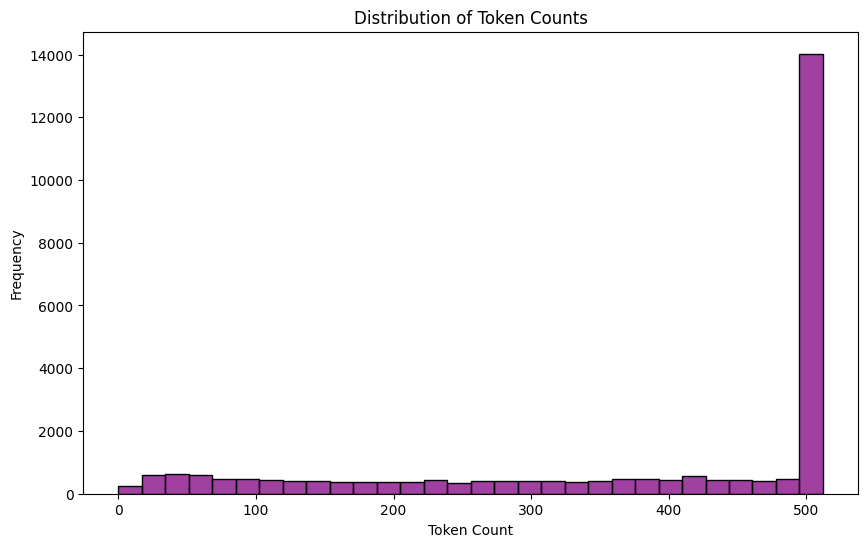

(count    26572.000000
 mean       385.970947
 std        166.989528
 min          0.000000
 25%        262.750000
 50%        512.000000
 75%        512.000000
 max        512.000000
 Name: token_count, dtype: float64,
 [('and', 530777),
  ('to', 269783),
  ('data', 188509),
  ('the', 188492),
  ('of', 179168),
  ('##s', 134690),
  ('in', 132109),
  ('a', 125469),
  ('with', 117133),
  ('for', 100307)])

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import ast


# Convert the 'tokens' column from string representation of list to actual lists
data_updated['tokens_list'] = data_updated['tokens'].apply(ast.literal_eval)

# Calculate the length of each token list for the token count analysis
data_updated['token_count'] = data_updated['tokens_list'].apply(len)

# Flatten all tokens into a single list for frequency analysis
all_tokens_updated = [token for sublist in data_updated['tokens_list'] for token in sublist]

# Count the occurrences of each token and identify the most common tokens
token_counts_updated = Counter(all_tokens_updated)
most_common_tokens_updated = token_counts_updated.most_common(10)

# Visualization of the Distribution of Token Counts
plt.figure(figsize=(10, 6))
sns.histplot(data_updated['token_count'], bins=30, color='purple')
plt.title('Distribution of Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# Basic statistics of token counts
token_count_stats_updated = data_updated['token_count'].describe()

token_count_stats_updated, most_common_tokens_updated


/var/folders/7v/b_qdblv15hg0h789msb73v4r0000gn/T/ipykernel_52103/360229305.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Token', data=most_common_tokens_df, palette='plasma')


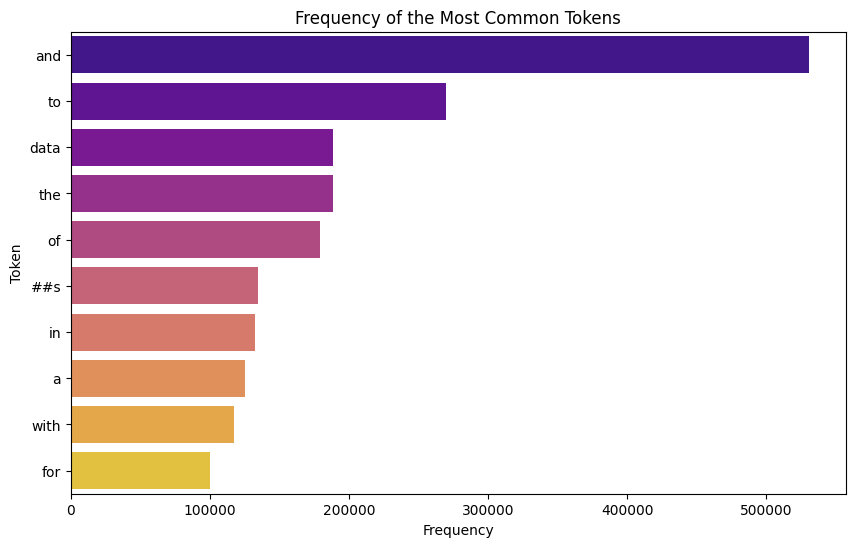

In [16]:
# Visualization of the Frequency of the Most Common Tokens
most_common_tokens_df = pd.DataFrame(most_common_tokens_updated, columns=['Token', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Token', data=most_common_tokens_df, palette='plasma')
plt.title('Frequency of the Most Common Tokens')
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.show()


/var/folders/7v/b_qdblv15hg0h789msb73v4r0000gn/T/ipykernel_52103/1121926054.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Entity', data=entities_df_updated.sort_values('Frequency', ascending=False), palette='viridis')


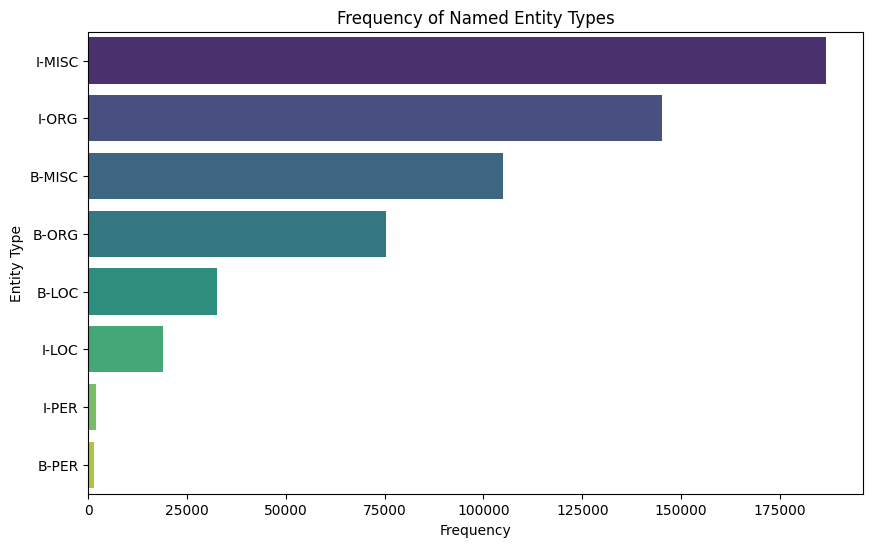

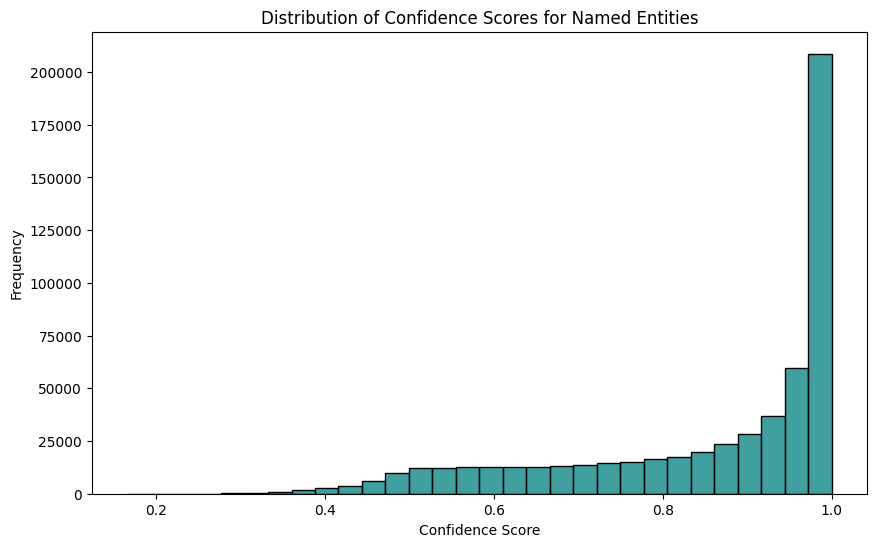

count    567298.000000
mean          0.853461
std           0.167628
min           0.165413
25%           0.749785
50%           0.933533
75%           0.987862
max           0.999797
dtype: float64

In [15]:
# NER Results Analysis: Extract entities and their confidence scores from the ner_results
entities_updated = []
scores_updated = []

for ner_result in data_updated['ner_results'].apply(ast.literal_eval):
    for entity_dict in ner_result:
        entities_updated.append(entity_dict['entity'])
        scores_updated.append(entity_dict['score'])

# Count the occurrences of each entity type and identify the most common entities
entity_counts_updated = Counter(entities_updated)

# Visualization of the Frequency of Named Entity Types
entities_df_updated = pd.DataFrame.from_dict(entity_counts_updated, orient='index').reset_index()
entities_df_updated.columns = ['Entity', 'Frequency']

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Entity', data=entities_df_updated.sort_values('Frequency', ascending=False), palette='viridis')
plt.title('Frequency of Named Entity Types')
plt.xlabel('Frequency')
plt.ylabel('Entity Type')
plt.show()

# Visualization of the Distribution of Confidence Scores
plt.figure(figsize=(10, 6))
sns.histplot(scores_updated, bins=30, color='teal')
plt.title('Distribution of Confidence Scores for Named Entities')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.show()

# Basic statistics of confidence scores
score_stats_updated = pd.Series(scores_updated).describe()

score_stats_updated


In [7]:
# Assuming you have a combined DataFrame 'combined_df' and you want to include both 'job_description' and 'job_id' for annotation,
# the following script demonstrates how to correctly extract these columns and save them to a new CSV file for uploading to Label Studio.

import pandas as pd

# Paths to your dataset CSV files
train_path = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/train_data.csv'
test_path = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/test_data.csv'
val_path = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/val_data.csv'

# Load the datasets from CSV files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
val_df = pd.read_csv(val_path)

# Combine the datasets
combined_df = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Specify the output file path for the combined dataset
output_file_path = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/combined_dataset.csv'

# Save the combined dataset to a CSV file
combined_df.to_csv(output_file_path, index=False)

print(f"Combined dataset saved to {output_file_path}")

Combined dataset saved to /Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/combined_dataset.csv


In [8]:
import pandas as pd

# Specify the path to the combined dataset
combined_path = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/combined_dataset.csv'

# Load the dataset
combined_df = pd.read_csv(combined_path)

# Select only the 'description' and 'job_id' columns
# Ensure these column names match your dataset
job_descriptions = combined_df[['description', 'job_id']]

# Randomly select 1000 rows from the DataFrame
sampled_job_descriptions = job_descriptions.sample(n=1000, random_state=42)

# Rename the columns to match what Label Studio expects
sampled_job_descriptions.columns = ['text', 'job_id']

# Specify the path for the new CSV file to save the 1000 job descriptions
output_file_path = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/sample_job_descriptions.csv'

# Save the sampled job descriptions and IDs to a new CSV file
sampled_job_descriptions.to_csv(output_file_path, index=False)

print(f"Sampled job descriptions saved to {output_file_path}")


Sampled job descriptions saved to /Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/data_transformation/sample_job_descriptions.csv
